# Chapter 14: Part-of-Speech and Sequence Annotation
## Part-of-Speech Tagging using Feedforward Networks and Embeddings

A part-of-speech tagger using feed-forward networks and trained on a corpus following the Universal Dependencies format. Here we use the English Web Treebank:
https://github.com/UniversalDependencies/UD_English-EWT/tree/master.

Programs from the book: [_Python for Natural Language Processing_](https://link.springer.com/book/9783031575488)

__Author__: Pierre Nugues

## Python Headers

### The Modules

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import numpy as np
import statistics

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report
import ud_datasets
from conll_dictorizer import CoNLLDictorizer

### Some Parameters

In [2]:
EPOCHS = 2  # 10
MINI_CORPUS = False
EMB_LARGE = True
LR = 0.005
LOWERCASE = True

In [3]:
random.seed(1234)
torch.manual_seed(1234)

## Preprocessing
We will use the GloVe pretrained embeddings (_Global Vectors for Word Representation_) from https://nlp.stanford.edu/projects/glove/ by Pennington et al. (2014).

Download the `glove.6B.zip` archive and extract its content. We will use either the 100d or 50d vectors. Move the corresponding files to your datasets folder.

In [4]:
PATH = '../datasets/embeddings/'

### GloVe

In [5]:
if EMB_LARGE:
    embedding_file = PATH + 'glove.6B.100d.txt'
    EMBEDDING_DIM = 100
else:
    embedding_file = PATH + 'glove.6B.50d.txt'
    EMBEDDING_DIM = 50

In [6]:
def read_embeddings(file: str) -> dict[str, torch.FloatTensor]:
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    with open(file) as glove:
        for line in glove:
            values = line.strip().split()
            word = values[0]
            vector = torch.FloatTensor(
                list(map(float, values[1:])))
            embeddings[word] = vector
    return embeddings

In [7]:
embeddings_dict = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings_dict.keys()))

### Loading the Corpus

In [8]:
CORPUS = 'EWT'

In [9]:
if CORPUS == 'EWT':
    train_sentences, val_sentences, test_sentences, column_names = ud_datasets.load_ud_en_ewt()
elif CORPUS == 'Talbanken':
    train_sentences, val_sentences, test_sentences, column_names = ud_datasets.load_ud_sv_talbanken()
elif CORPUS == 'GSD':
    train_sentences, val_sentences, test_sentences, column_names = ud_datasets.load_ud_fr_gsd()

## Dictorizing the corpus

We store the corpus word in a dictionary, where the keys are the CoNLL-U columns

In [10]:
conll_dict = CoNLLDictorizer(column_names)

In [11]:
train_dict = conll_dict.transform(train_sentences)
val_dict = conll_dict.transform(val_sentences)
test_dict = conll_dict.transform(test_sentences)

In [12]:
train_dict[0][:10]

[{'ID': '1',
  'FORM': 'Al',
  'LEMMA': 'Al',
  'UPOS': 'PROPN',
  'XPOS': 'NNP',
  'FEATS': 'Number=Sing',
  'HEAD': '0:root',
  'DEPREL': 'root',
  'DEPS': 'SpaceAfter=No'},
 {'ID': '2',
  'FORM': '-',
  'LEMMA': '-',
  'UPOS': 'PUNCT',
  'XPOS': 'HYPH',
  'FEATS': '_',
  'HEAD': '3:punct',
  'DEPREL': 'punct',
  'DEPS': 'SpaceAfter=No'},
 {'ID': '3',
  'FORM': 'Zaman',
  'LEMMA': 'Zaman',
  'UPOS': 'PROPN',
  'XPOS': 'NNP',
  'FEATS': 'Number=Sing',
  'HEAD': '1:flat',
  'DEPREL': 'flat',
  'DEPS': '_'},
 {'ID': '4',
  'FORM': ':',
  'LEMMA': ':',
  'UPOS': 'PUNCT',
  'XPOS': ':',
  'FEATS': '_',
  'HEAD': '7:punct',
  'DEPREL': 'punct',
  'DEPS': '_'},
 {'ID': '5',
  'FORM': 'American',
  'LEMMA': 'American',
  'UPOS': 'ADJ',
  'XPOS': 'JJ',
  'FEATS': 'Degree=Pos',
  'HEAD': '6:amod',
  'DEPREL': 'amod',
  'DEPS': '_'},
 {'ID': '6',
  'FORM': 'forces',
  'LEMMA': 'force',
  'UPOS': 'NOUN',
  'XPOS': 'NNS',
  'FEATS': 'Number=Plur',
  'HEAD': '7:nsubj',
  'DEPREL': 'nsubj',
  'DEPS

In [13]:
if MINI_CORPUS:
    train_dict = train_dict[:len(train_dict) // 5]
print('First sentence, train:', train_dict[0])

First sentence, train: [{'ID': '1', 'FORM': 'Al', 'LEMMA': 'Al', 'UPOS': 'PROPN', 'XPOS': 'NNP', 'FEATS': 'Number=Sing', 'HEAD': '0:root', 'DEPREL': 'root', 'DEPS': 'SpaceAfter=No'}, {'ID': '2', 'FORM': '-', 'LEMMA': '-', 'UPOS': 'PUNCT', 'XPOS': 'HYPH', 'FEATS': '_', 'HEAD': '3:punct', 'DEPREL': 'punct', 'DEPS': 'SpaceAfter=No'}, {'ID': '3', 'FORM': 'Zaman', 'LEMMA': 'Zaman', 'UPOS': 'PROPN', 'XPOS': 'NNP', 'FEATS': 'Number=Sing', 'HEAD': '1:flat', 'DEPREL': 'flat', 'DEPS': '_'}, {'ID': '4', 'FORM': ':', 'LEMMA': ':', 'UPOS': 'PUNCT', 'XPOS': ':', 'FEATS': '_', 'HEAD': '7:punct', 'DEPREL': 'punct', 'DEPS': '_'}, {'ID': '5', 'FORM': 'American', 'LEMMA': 'American', 'UPOS': 'ADJ', 'XPOS': 'JJ', 'FEATS': 'Degree=Pos', 'HEAD': '6:amod', 'DEPREL': 'amod', 'DEPS': '_'}, {'ID': '6', 'FORM': 'forces', 'LEMMA': 'force', 'UPOS': 'NOUN', 'XPOS': 'NNS', 'FEATS': 'Number=Plur', 'HEAD': '7:nsubj', 'DEPREL': 'nsubj', 'DEPS': '_'}, {'ID': '7', 'FORM': 'killed', 'LEMMA': 'kill', 'UPOS': 'VERB', 'XPOS'

### Extracting the Context and Dictorizing it
We extract windows of five words surrounding the word

In [14]:
def extract_cols(sent_dict, x='FORM', y='UPOS'):
    (input, target) = ([], [])
    for word in sent_dict:
        input += [word[x]]
        target += [word.get(y, None)]
    return input, target

In [15]:
train_cols = [extract_cols(sent_dict)
              for sent_dict in train_dict]
val_cols = [extract_cols(sent_dict)
            for sent_dict in val_dict]
test_cols = [extract_cols(sent_dict)
             for sent_dict in test_dict]

In [16]:
train_sent_words, train_sent_pos = zip(*train_cols)
val_sent_words, val_sent_pos = zip(*val_cols)
test_sent_words, test_sent_pos = zip(*test_cols)

We set the words in lowercase

In [17]:
if LOWERCASE:
    train_sent_words = [list(map(str.lower, sent_words))
                        for sent_words in train_sent_words]
    val_sent_words = [list(map(str.lower, sent_words))
                      for sent_words in val_sent_words]
    test_sent_words = [list(map(str.lower, sent_words))
                       for sent_words in test_sent_words]

In [18]:
train_sent_words[8131]

['or', 'you', 'can', 'visit', 'temples', 'or', 'shrines', 'in', 'okinawa', '.']

In [19]:
def create_X_cat(sentence: list[str],
                 w_size: int = 2) -> list[dict[int: str]]:
    start_pads = ['__BOS__'] * w_size
    end_pads = ['__EOS__'] * w_size
    sentence = start_pads + sentence + end_pads
    # We extract the features
    X = []
    for i in range(len(sentence) - 2 * w_size):
        x = []
        for j in range(2 * w_size + 1):
            x += [sentence[i + j]]
        X += [x]
    X = [dict(enumerate(x)) for x in X]
    return X

In [20]:
create_X_cat(train_sent_words[8131])

[{0: '__BOS__', 1: '__BOS__', 2: 'or', 3: 'you', 4: 'can'},
 {0: '__BOS__', 1: 'or', 2: 'you', 3: 'can', 4: 'visit'},
 {0: 'or', 1: 'you', 2: 'can', 3: 'visit', 4: 'temples'},
 {0: 'you', 1: 'can', 2: 'visit', 3: 'temples', 4: 'or'},
 {0: 'can', 1: 'visit', 2: 'temples', 3: 'or', 4: 'shrines'},
 {0: 'visit', 1: 'temples', 2: 'or', 3: 'shrines', 4: 'in'},
 {0: 'temples', 1: 'or', 2: 'shrines', 3: 'in', 4: 'okinawa'},
 {0: 'or', 1: 'shrines', 2: 'in', 3: 'okinawa', 4: '.'},
 {0: 'shrines', 1: 'in', 2: 'okinawa', 3: '.', 4: '__EOS__'},
 {0: 'in', 1: 'okinawa', 2: '.', 3: '__EOS__', 4: '__EOS__'}]

In [21]:
X_train_cat = [row for sent in train_sent_words
               for row in create_X_cat(sent)]
X_val_cat = [row for sent in val_sent_words
             for row in create_X_cat(sent)]
X_test_cat = [row for sent in test_sent_words
              for row in create_X_cat(sent)]

In [22]:
y_train_cat = [pos for sent in train_sent_pos
               for pos in sent]
y_val_cat = [pos for sent in val_sent_pos
             for pos in sent]
y_test_cat = [pos for sent in test_sent_pos
              for pos in sent]

### Running the Feature Extraction

We extract all the words

In [23]:
corpus_words = [value.lower() for x in X_train_cat
                for value in x.values()]
corpus_words = sorted(set(corpus_words))

print('# unique words seen in training corpus:', len(corpus_words))

# unique words seen in training corpus: 17115


In [24]:
embeddings_words = embeddings_dict.keys()
print('Words in GloVe:',  len(embeddings_dict.keys()))
vocabulary = set(corpus_words + list(embeddings_words))

Words in GloVe: 400000


In [25]:
print('# unique words in the vocabulary: embeddings and corpus:',
      len(vocabulary) + 1)

# unique words in the vocabulary: embeddings and corpus: 402012


In [26]:
idx2word = dict(enumerate(sorted(vocabulary), start=1))
word2idx = {v: k for k, v in idx2word.items()}

We set the words in lowercase as GloVe is lowercase and we replace them with their index.

In [27]:
for x_train_cat in X_train_cat:
    for word in x_train_cat:
        x_train_cat[word] = word2idx[
            x_train_cat[word].lower()]

for x_val_cat in X_val_cat:
    for word in x_val_cat:
        x_val_cat[word] = word2idx.get(
            x_val_cat[word].lower(), 0)

for x_test_cat in X_test_cat:
    for word in x_test_cat:
        x_test_cat[word] = word2idx.get(
            x_test_cat[word].lower(), 0)

### Vectorizing the ${X}$ Matrix

In [30]:
dict_vectorizer = DictVectorizer(dtype=np.int64, sparse=False)
X_train = dict_vectorizer.fit_transform(X_train_cat)
X_val = dict_vectorizer.transform(X_val_cat)
X_test = dict_vectorizer.transform(X_test_cat)

In [31]:
X_train.shape

(207229, 5)

In [32]:
X_train[0]

array([ 43517,  43517,  50471,    654, 397777])

### Vectorizing $\mathbf{y}$

We create a torch matrix of size $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in GloVe, and $N$, the dimension of the embeddings.
The padding symbol and the unknown word symbol will be part of the vocabulary at respectively index 0 and 1. 

We initialize the matrix with random values with the `torch.rand()`

In [33]:
# embedding_matrix = nn.Embedding(len(vocabulary) + 2, EMBEDDING_DIM).weight.requires_grad_(False)

In [34]:
# We add two dimensions for the  unknown words at index 0
# embedding_table = torch.rand(
#    (len(vocabulary) + 1, EMBEDDING_DIM))/10 - 0.05  # range: -0.05, 0.05,
# embedding_table = torch.rand((len(vocabulary) + 1, EMBEDDING_DIM)) - 0.5
# embedding_table = torch.zeros((len(vocabulary) + 1, EMBEDDING_DIM))
embedding_table = torch.randn(
    (len(vocabulary) + 1, EMBEDDING_DIM))/10

The size of the matrix is: (411326, 100) or (411326, 50)

In [35]:
embedding_table.size()

torch.Size([402012, 100])

We fill the matrix with the GloVe embeddings when available. This means: We replace the random vector with an embedding when available. We will use the indices from the previous section. We call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [36]:
out_of_embeddings = []
for word in vocabulary:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_table[word2idx[word]] = embeddings_dict[word]
    else:
        # Otherwise, it keeps a random value in the matrix
        # We store the out of vocabulary words
        out_of_embeddings += [word]

In [37]:
len(out_of_embeddings)

2011

In [38]:
out_of_embeddings[-10:]

['gstrathmann@mediaone.net',
 "ain't",
 'president’s',
 "global's",
 'brianp@aiglincoln.com',
 'omfg',
 'palces',
 '11/22/2000',
 'ymsgr:sendim?mayursha&__hi+mayur...',
 'kalkat']

Embeddings of the padding symbol, idx 0, random numbers

In [39]:
embedding_table[0][:10]

tensor([-0.0112, -0.0497,  0.0163, -0.0882,  0.0054,  0.0668, -0.0060, -0.0467,
        -0.0215,  0.0884])

Embeddings of the word _table_, the GloVe values

In [40]:
embedding_table[word2idx['table']][:10]

tensor([-0.6145,  0.8969,  0.5677,  0.3910, -0.2244,  0.4904,  0.1087,  0.2741,
        -0.2383, -0.5215])

Embeddings of _äänekoski_, a word in IMDB, but not in GloVe, random numbers

In [41]:
embedding_table[word2idx['saucey']][:10]

tensor([ 0.0505, -0.1034,  0.1383, -0.0746, -0.0614, -0.0361,  0.1039, -0.1105,
         0.0637,  0.1705])

The POS and the number of different POS

In [42]:
pos_list = sorted(set(y_train_cat))
NB_CLASSES = len(pos_list)
pos_list

['ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB',
 'X',
 '_']

We build a part-of-speech index. We keep 0 for unknown symbols in the test set

In [43]:
idx2pos = dict(enumerate(pos_list))
pos2idx = {v: k for k, v in idx2pos.items()}
print(idx2pos)
pos2idx

{0: 'ADJ', 1: 'ADP', 2: 'ADV', 3: 'AUX', 4: 'CCONJ', 5: 'DET', 6: 'INTJ', 7: 'NOUN', 8: 'NUM', 9: 'PART', 10: 'PRON', 11: 'PROPN', 12: 'PUNCT', 13: 'SCONJ', 14: 'SYM', 15: 'VERB', 16: 'X', 17: '_'}


{'ADJ': 0,
 'ADP': 1,
 'ADV': 2,
 'AUX': 3,
 'CCONJ': 4,
 'DET': 5,
 'INTJ': 6,
 'NOUN': 7,
 'NUM': 8,
 'PART': 9,
 'PRON': 10,
 'PROPN': 11,
 'PUNCT': 12,
 'SCONJ': 13,
 'SYM': 14,
 'VERB': 15,
 'X': 16,
 '_': 17}

We encode $\mathbf{y}$. We use one symbol for unknown parts of speech in the test set

In [44]:
y_train = torch.LongTensor([pos2idx[i] for i in y_train_cat])
y_val = torch.LongTensor([pos2idx[i] for i in y_val_cat])
y_test = torch.LongTensor([pos2idx[i] for i in y_test_cat])

In [45]:
y_train_cat[:10]

['PROPN',
 'PUNCT',
 'PROPN',
 'PUNCT',
 'ADJ',
 'NOUN',
 'VERB',
 'PROPN',
 'PROPN',
 'PROPN']

In [46]:
y_train[:10]

tensor([11, 12, 11, 12,  0,  7, 15, 11, 11, 11])

## The Tagger
Our models

In [47]:
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
X_test = torch.from_numpy(X_test)

In [48]:
X_train.size(dim=1)

5

In [49]:
model = nn.Sequential(
    nn.Embedding.from_pretrained(
        embedding_table, freeze=False),
    nn.Flatten(),
    nn.Linear(5 * embedding_table.size(dim=1),
              len(pos2idx))
)

In [50]:
loss_fn = nn.CrossEntropyLoss()    # cross entropy loss
optimizer = torch.optim.NAdam(model.parameters(), lr=LR)

In [51]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(
    train_dataset, batch_size=512, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(
    val_dataset, batch_size=2048, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(
    test_dataset, batch_size=2048, shuffle=False)

In [52]:
def evaluate(model,
             loss_fn,
             dataloader) -> tuple[float, float]:
    model.eval()
    with torch.no_grad():
        loss = 0
        acc = 0
        batch_cnt = 0
        for X_batch, y_batch in dataloader:
            batch_cnt += 1
            y_batch_pred = model(X_batch)
            loss += loss_fn(y_batch_pred, y_batch).item()
            acc += (sum(torch.argmax(y_batch_pred, dim=-1)
                    == y_batch)/y_batch.size(dim=0)).item()
        return loss/batch_cnt, acc/batch_cnt

In [53]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

In [54]:
for epoch in range(EPOCHS):
    train_loss = 0
    train_acc = 0
    batch_cnt = 0
    model.train()
    for X_batch, y_batch in tqdm(train_dataloader):
        batch_cnt += 1
        y_batch_pred = model(X_batch)
        loss = loss_fn(y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc += (sum(
            torch.argmax(y_batch_pred, dim=-1)
            == y_batch)/y_batch.size(dim=0)).item()
        train_loss += loss.item()
    model.eval()
    with torch.no_grad():
        history['accuracy'] += [train_acc/batch_cnt]
        history['loss'] += [train_loss/batch_cnt]
        val_loss, val_acc = evaluate(model, loss_fn, val_dataloader)
        history['val_loss'] += [val_loss]
        history['val_accuracy'] += [val_acc]

100%|██████████| 405/405 [00:28<00:00, 14.06it/s]


In [55]:
history['val_accuracy']

[0.9308907068692721, 0.9354168589298542]

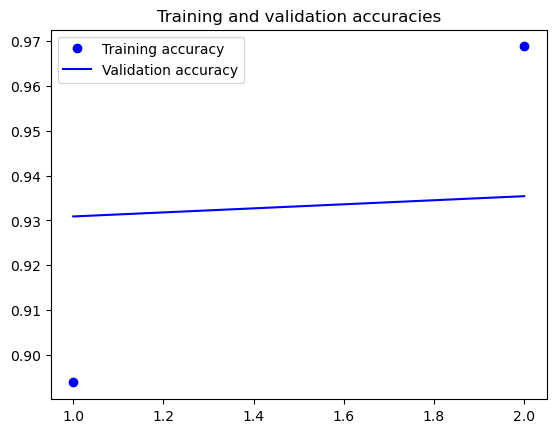

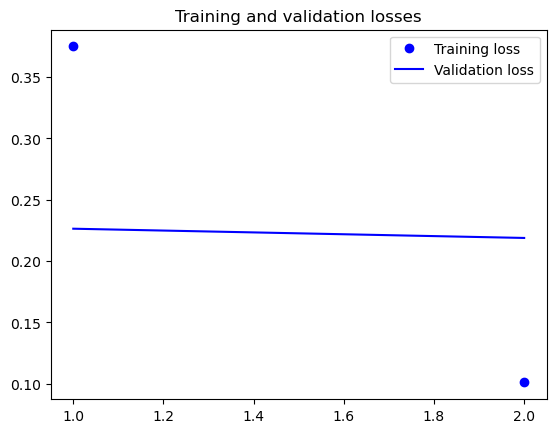

In [56]:
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

plt.show()

### Predicting a Value

In [57]:
Y_test_pred = model(X_test)
Y_test_pred

tensor([[ -2.0572,  -4.1297,   0.3404,  ...,   0.1244,  -3.3643,  -0.6337],
        [ -3.8549,   1.5344,  -1.2403,  ...,  -0.5274,   0.9158,  -4.6087],
        [ -1.4975,  -2.9834,  -0.0968,  ...,   4.7082,   1.0959,  -1.9606],
        ...,
        [ -3.2674,   8.2534,   1.1015,  ...,  -2.9229,  -1.5195,  -7.8813],
        [  0.3650,  -2.6970,  -0.4175,  ...,   9.4591,  -2.3103,  -7.8934],
        [ -1.7998,  -0.5051,  -0.0736,  ...,  -6.7083,  -0.1545, -10.1365]],
       grad_fn=<AddmmBackward0>)

In [58]:
y_test_pred = torch.argmax(model(X_test), dim=-1)
y_test_pred

tensor([10, 13, 11,  ...,  9, 15, 12])

In [59]:
list(map(lambda x: idx2pos.get(x, 'UNK'),
     torch.argmax(model(X_test), dim=-1).tolist()))

['PRON',
 'SCONJ',
 'PROPN',
 'VERB',
 'ADP',
 'NOUN',
 'PUNCT',
 'PRON',
 'SCONJ',
 'PROPN',
 'VERB',
 'ADP',
 'PRON',
 'NOUN',
 'PUNCT',
 'NOUN',
 'PUNCT',
 'CCONJ',
 'ADV',
 'NOUN',
 'PUNCT',
 'VERB',
 'ADP',
 'DET',
 'ADJ',
 'PUNCT',
 'ADJ',
 'NOUN',
 'NOUN',
 'PUNCT',
 'PUNCT',
 'ADP',
 'PROPN',
 'VERB',
 'ADP',
 'PROPN',
 'PROPN',
 'PROPN',
 'PUNCT',
 'PUNCT',
 'CCONJ',
 'PUNCT',
 'ADP',
 'DET',
 'NOUN',
 'PUNCT',
 'AUX',
 'PRON',
 'ADJ',
 'ADV',
 'DET',
 'ADJ',
 'ADJ',
 'ADP',
 'DET',
 'NOUN',
 'ADV',
 'PRON',
 'AUX',
 'DET',
 'ADJ',
 'NOUN',
 'PUNCT',
 'PUNCT',
 'DET',
 'NOUN',
 'NOUN',
 'VERB',
 'SCONJ',
 '_',
 'PROPN',
 'PART',
 'VERB',
 'ADP',
 'NOUN',
 'AUX',
 'ADV',
 'PUNCT',
 'PRON',
 '_',
 'PRON',
 'AUX',
 'DET',
 'VERB',
 'ADV',
 'PUNCT',
 'CCONJ',
 '_',
 'PRON',
 'AUX',
 'ADV',
 'ADV',
 'PUNCT',
 'VERB',
 'ADP',
 'DET',
 'NOUN',
 'PUNCT',
 'PROPN',
 'AUX',
 'DET',
 'ADJ',
 'VERB',
 'NOUN',
 'PUNCT',
 'AUX',
 'PRON',
 'VERB',
 'PRON',
 'ADP',
 'PRON',
 'ADJ',
 'PUNCT',


### Testing the Model

In [60]:
acc_loss, acc_test = evaluate(model, loss_fn, test_dataloader)
acc_loss, acc_test

(0.2121364141886051, 0.9371945353654715)

In [61]:
target_names = sorted(pos2idx.keys(), key=lambda x: pos2idx[x])

In [62]:
print(classification_report(y_test_pred, y_test,
      digits=4, target_names=target_names))

              precision    recall  f1-score   support

         ADJ     0.9133    0.9143    0.9138      1786
         ADP     0.9626    0.9413    0.9519      2080
         ADV     0.8827    0.9186    0.9003      1130
         AUX     0.9799    0.9863    0.9831      1533
       CCONJ     0.9932    0.9919    0.9925       738
         DET     0.9895    0.9853    0.9874      1905
        INTJ     0.8500    0.8947    0.8718       114
        NOUN     0.9115    0.8925    0.9019      4225
         NUM     0.8635    0.9159    0.8889       511
        PART     0.9831    0.9696    0.9763       658
        PRON     0.9875    0.9812    0.9843      2176
       PROPN     0.7872    0.8619    0.8228      1897
       PUNCT     0.9910    0.9929    0.9919      3090
       SCONJ     0.8438    0.8950    0.8686       362
         SYM     0.8899    0.7519    0.8151       129
        VERB     0.9601    0.9101    0.9345      2749
           X     0.0000    0.0000    0.0000        12
           _     0.9915    

About 93.34 for the large embeddings

## Prediction of parts of speech

In [63]:
def predict_sentence(sentence,
                     model,
                     word2idx,
                     idx2pos,
                     dict_vectorizer,
                     ppos_key='PPOS', lc=True):
    sent_words, _ = extract_cols(sentence)
    if lc:
        sent_words = list(map(str.lower, sent_words))
    X_cat = create_X_cat(sent_words)
    for x_cat in X_cat:
        for word in x_cat:
            x_cat[word] = word2idx.get(x_cat[word].lower(), 0)
    X = dict_vectorizer.transform(X_cat)
    y_pred_vec = torch.argmax(model(torch.from_numpy(X).long()),
                              dim=-1)
    # We add the predictions in the PPOS column
    for row, y_pred in zip(sentence, y_pred_vec):
        row[ppos_key] = idx2pos[y_pred.item()]
    return sentence

In [64]:
sentences = ["That round table might collapse .",
             "The man can learn well .",
             "The man can swim .",
             "The man can simwo ."]

In [65]:
def sentence_to_conll(sentence: str):
    sent_dict = [{'ID': x, 'FORM': y} for (x, y) in
                 enumerate(sentence.split(), start=1)]
    return sent_dict

In [66]:
for sentence in sentences:
    sentence = sentence_to_conll(sentence)
    y_test_pred_cat = predict_sentence(sentence,
                                       model,
                                       word2idx,
                                       idx2pos,
                                       dict_vectorizer, lc=LOWERCASE)
    print([y['FORM'] for y in y_test_pred_cat])
    print([y['PPOS'] for y in y_test_pred_cat])

['That', 'round', 'table', 'might', 'collapse', '.']
['DET', 'DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
['The', 'man', 'can', 'learn', 'well', '.']
['DET', 'NOUN', 'AUX', 'VERB', 'ADV', 'PUNCT']
['The', 'man', 'can', 'swim', '.']
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
['The', 'man', 'can', 'simwo', '.']
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
